0.21821345281573287
0.21821345281573287


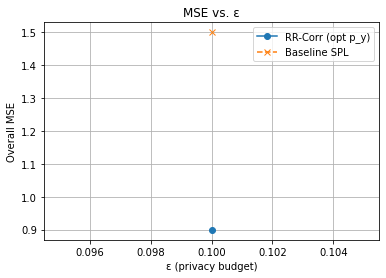

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- your existing GRR primitives ---
def grr_perturb(x, domain, epsilon):
    k = len(domain)
    p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)
    if np.random.rand() < p:
        return x
    return np.random.choice([v for v in domain if v != x])

def grr_estimate_frequencies(reports, domain, epsilon):
    n, k = len(reports), len(domain)
    p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)
    q = 1.0 / (np.exp(epsilon) + k - 1)
    counts = {v: 0 for v in domain}
    for r in reports:
        counts[r] += 1
    return {v: (counts[v] - n*q) / (n*(p - q)) for v in domain}

# --- closed-form p_y optimizer (unchanged) ---
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0   / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1))
                 for v in domain)
    α2 =   sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2
                 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den =      a1**2/(2*n)   - α2/(4*d)

    p_star = num/den if den != 0 else 0.0
    print(p_star)
    py_clipped = float(np.clip(p_star, 0.0, 1.0))
    print(py_clipped)
    return py_clipped


# --- RR-Corr with automatic p_y ---
def rr_corr(df, domain1, domain2, epsilon, m):
    n = len(df)
    eps2 = epsilon/2
    idx = np.random.permutation(n)
    idx_a, idx_b = idx[:m], idx[m:]

    # Phase A
    Y1_a, Y2_a = [], []
    for i in idx_a:
        x1, x2 = df.iloc[i]['X1'], df.iloc[i]['X2']
        Y1_a.append(grr_perturb(x1, domain1, eps2))
        Y2_a.append(grr_perturb(x2, domain2, eps2))
    f1_a = grr_estimate_frequencies(Y1_a, domain1, eps2)
    f2_a = grr_estimate_frequencies(Y2_a, domain2, eps2)

    # infer cov (optional)
    cov_Y = np.cov(Y1_a, Y2_a, ddof=1)[0,1]
    p_a1 = np.exp(eps2)/(np.exp(eps2)+len(domain1)-1)
    p_a2 = np.exp(eps2)/(np.exp(eps2)+len(domain2)-1)
    cov_X = cov_Y / (p_a1 * p_a2)

    # compute optimal p_y
    p_y = optimal_p_y(f1_a, f2_a, epsilon, n, domain1)

    # Phase B
    Y1_b, Y2_b = [], []
    for i in idx_b:
        x1, x2 = df.iloc[i]['X1'], df.iloc[i]['X2']
        if np.random.rand() < 0.5:
            y1 = grr_perturb(x1, domain1, epsilon)
            if np.random.rand() < p_y:
                y2 = y1
            else:
                y2 = np.random.choice([v for v in domain2 if v != y1])
        else:
            y2 = grr_perturb(x2, domain2, epsilon)
            if np.random.rand() < p_y:
                y1 = y2
            else:
                y1 = np.random.choice([v for v in domain1 if v != y2])
        Y1_b.append(y1)
        Y2_b.append(y2)

    f1_b = grr_estimate_frequencies(Y1_b, domain1, epsilon)
    f2_b = grr_estimate_frequencies(Y2_b, domain2, epsilon)

    hat_f1 = {v: (m*f1_a[v] + (n-m)*f1_b[v]) / n for v in domain1}
    hat_f2 = {v: (m*f2_a[v] + (n-m)*f2_b[v]) / n for v in domain2}
    return hat_f1, hat_f2, cov_X


# --- Corrected baseline: SPL + GRR on both attrs ---
def random_split_perturb(df, domain1, domain2, epsilon):
    eps2 = epsilon / 2
    pert = []
    for _, row in df.iterrows():
        y1 = grr_perturb(row['X1'], domain1, eps2)
        y2 = grr_perturb(row['X2'], domain2, eps2)
        pert.append((y1, y2))
    return pert

def random_split_estimate(reports, domain1, domain2, epsilon):
    eps2 = epsilon / 2
    rep1 = [y1 for y1, _ in reports]
    rep2 = [y2 for _, y2 in reports]
    f1 = grr_estimate_frequencies(rep1, domain1, eps2)
    f2 = grr_estimate_frequencies(rep2, domain2, eps2)
    return f1, f2


# --- MSE vs ε plot ---
domain = sorted(df['X1'].unique())
true_freq1 = df['X1'].value_counts(normalize=True).sort_index().to_dict()
true_freq2 = df['X2'].value_counts(normalize=True).sort_index().to_dict()
n = len(df)
m = int(0.5 * n)

epsilons = [0.1]
mse_rrcorr = []
mse_baseline = []

for eps in epsilons:
    # RR-Corr
    hat1, hat2, _ = rr_corr(df, domain, domain, eps, m)
    mse1 = np.mean([(hat1[v] - true_freq1[v])**2 for v in domain])
    mse2 = np.mean([(hat2[v] - true_freq2[v])**2 for v in domain])
    mse_rrcorr.append((mse1 + mse2) / 2)

    # baseline SPL
    pert = random_split_perturb(df, domain, domain, eps)
    est1, est2 = random_split_estimate(pert, domain, domain, eps)
    mse1_s = np.mean([(est1[v] - true_freq1[v])**2 for v in domain])
    mse2_s = np.mean([(est2[v] - true_freq2[v])**2 for v in domain])
    mse_baseline.append((mse1_s + mse2_s) / 2)

plt.figure(figsize=(6,4))
plt.plot(epsilons, mse_rrcorr, 'o-', label='RR-Corr (opt p_y)')
plt.plot(epsilons, mse_baseline, 'x--', label='Baseline SPL')
plt.xlabel('ε (privacy budget)')
plt.ylabel('Overall MSE')
plt.title('MSE vs. ε')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Generate synthetic dataset with controllable correlation
n = 10000
domain = [0, 1]
p_same = 0.7  # probability that X2 equals X1

# Sample X1 uniformly over the domain
X1 = np.random.choice(domain, size=n)

# For each X1 value, with probability p_same set X2 = X1,
# otherwise sample X2 uniformly from the other domain values
X2 = [
    x if np.random.rand() < p_same
    else np.random.choice([d for d in domain if d != x])
    for x in X1
]

# Build DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2})

# Display first few rows to confirm
print(df.head())

# ---- Now you can pass `df` into rr_corr, baseline, and the MSE-vs-epsilon plot ----



   X1  X2
0   1   0
1   1   1
2   0   0
3   0   1
4   1   1


0.7644550120772948
0.7644550120772948


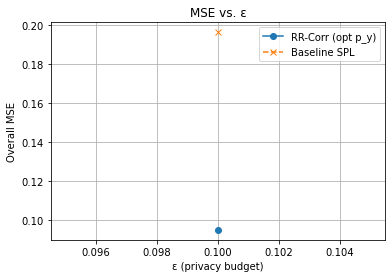

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- your existing GRR primitives ---
def grr_perturb(x, domain, epsilon):
    k = len(domain)
    p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)
    if np.random.rand() < p:
        return x
    return np.random.choice([v for v in domain if v != x])

def grr_estimate_frequencies(reports, domain, epsilon):
    n, k = len(reports), len(domain)
    p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)
    q = 1.0 / (np.exp(epsilon) + k - 1)
    counts = {v: 0 for v in domain}
    for r in reports:
        counts[r] += 1
    return {v: (counts[v] - n*q) / (n*(p - q)) for v in domain}

# --- closed-form p_y optimizer (unchanged) ---
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0   / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1))
                 for v in domain)
    α2 =   sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2
                 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den =      a1**2/(2*n)   - α2/(4*d)

    p_star = num/den if den != 0 else 0.0
    print(p_star)
    py_clipped = float(np.clip(p_star, 0.0, 1.0))
    print(py_clipped)
    return py_clipped


# --- RR-Corr with automatic p_y ---
def rr_corr(df, domain1, domain2, epsilon, m):
    n = len(df)
    eps2 = epsilon/2
    idx = np.random.permutation(n)
    idx_a, idx_b = idx[:m], idx[m:]

    # Phase A
    Y1_a, Y2_a = [], []
    for i in idx_a:
        x1, x2 = df.iloc[i]['X1'], df.iloc[i]['X2']
        Y1_a.append(grr_perturb(x1, domain1, eps2))
        Y2_a.append(grr_perturb(x2, domain2, eps2))
    f1_a = grr_estimate_frequencies(Y1_a, domain1, eps2)
    f2_a = grr_estimate_frequencies(Y2_a, domain2, eps2)

    # infer cov (optional)
    cov_Y = np.cov(Y1_a, Y2_a, ddof=1)[0,1]
    p_a1 = np.exp(eps2)/(np.exp(eps2)+len(domain1)-1)
    p_a2 = np.exp(eps2)/(np.exp(eps2)+len(domain2)-1)
    cov_X = cov_Y / (p_a1 * p_a2)

    # compute optimal p_y
    p_y = optimal_p_y(f1_a, f2_a, epsilon, n, domain1)

    # Phase B
    Y1_b, Y2_b = [], []
    for i in idx_b:
        x1, x2 = df.iloc[i]['X1'], df.iloc[i]['X2']
        if np.random.rand() < 0.5:
            y1 = grr_perturb(x1, domain1, epsilon)
            if np.random.rand() < p_y:
                y2 = y1
            else:
                y2 = np.random.choice([v for v in domain2 if v != y1])
        else:
            y2 = grr_perturb(x2, domain2, epsilon)
            if np.random.rand() < p_y:
                y1 = y2
            else:
                y1 = np.random.choice([v for v in domain1 if v != y2])
        Y1_b.append(y1)
        Y2_b.append(y2)

    f1_b = grr_estimate_frequencies(Y1_b, domain1, epsilon)
    f2_b = grr_estimate_frequencies(Y2_b, domain2, epsilon)

    hat_f1 = {v: (m*f1_a[v] + (n-m)*f1_b[v]) / n for v in domain1}
    hat_f2 = {v: (m*f2_a[v] + (n-m)*f2_b[v]) / n for v in domain2}
    return hat_f1, hat_f2, cov_X


# --- Corrected baseline: SPL + GRR on both attrs ---
def random_split_perturb(df, domain1, domain2, epsilon):
    eps2 = epsilon / 2
    pert = []
    for _, row in df.iterrows():
        y1 = grr_perturb(row['X1'], domain1, eps2)
        y2 = grr_perturb(row['X2'], domain2, eps2)
        pert.append((y1, y2))
    return pert

def random_split_estimate(reports, domain1, domain2, epsilon):
    eps2 = epsilon / 2
    rep1 = [y1 for y1, _ in reports]
    rep2 = [y2 for _, y2 in reports]
    f1 = grr_estimate_frequencies(rep1, domain1, eps2)
    f2 = grr_estimate_frequencies(rep2, domain2, eps2)
    return f1, f2


# --- MSE vs ε plot ---
# 1) Generate synthetic dataset with controllable correlation
n = 1000
domain = [0, 1]
p_same = 1  # probability that X2 equals X1

# Sample X1 uniformly over the domain
X1 = np.random.choice(domain, size=n)

# For each X1 value, with probability p_same set X2 = X1,
# otherwise sample X2 uniformly from the other domain values
X2 = [
    x if np.random.rand() < p_same
    else np.random.choice([d for d in domain if d != x])
    for x in X1
]

# Build DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2})
n = len(df)
m = int(0.5 * n)

epsilons = [0.1]
mse_rrcorr = []
mse_baseline = []

for eps in epsilons:
    # RR-Corr
    hat1, hat2, _ = rr_corr(df, domain, domain, eps, m)
    mse1 = np.mean([(hat1[v] - true_freq1[v])**2 for v in domain])
    mse2 = np.mean([(hat2[v] - true_freq2[v])**2 for v in domain])
    mse_rrcorr.append((mse1 + mse2) / 2)

    # baseline SPL
    pert = random_split_perturb(df, domain, domain, eps)
    est1, est2 = random_split_estimate(pert, domain, domain, eps)
    mse1_s = np.mean([(est1[v] - true_freq1[v])**2 for v in domain])
    mse2_s = np.mean([(est2[v] - true_freq2[v])**2 for v in domain])
    mse_baseline.append((mse1_s + mse2_s) / 2)

plt.figure(figsize=(6,4))
plt.plot(epsilons, mse_rrcorr, 'o-', label='RR-Corr (opt p_y)')
plt.plot(epsilons, mse_baseline, 'x--', label='Baseline SPL')
plt.xlabel('ε (privacy budget)')
plt.ylabel('Overall MSE')
plt.title('MSE vs. ε')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0   / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1))
                 for v in domain)
    α2 =   sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2
                 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den =      a1**2/(2*n)   - α2/(4*d)

    p_star = num/den if den != 0 else 0.0
    print(p_star)
    py_clipped = float(np.clip(p_star, 0.0, 1.0))
    print(py_clipped)
    return py_clipped

In [70]:
import numpy as np

# Define a domain
domain = list(range(1))  # domain with values [0, 1, 2, 3, 4]

# Define two distributions over the domain
f_a = {0: 0.3}
f_b = {0: 0.3}

# Define parameters
epsilon = 0.1
n = 1000

# Run the function
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0   / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1))
                 for v in domain)
    α2 =   sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2
                 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den =      a1**2/(2*n)   - α2/(4*d)

    p_star = num/den if den != 0 else 0.0
    print("Raw p* =", p_star)
    py_clipped = float(np.clip(p_star, 0.0, 1.0))
    print("Clipped p* =", py_clipped)
    return py_clipped

# Call the function
result = optimal_p_y(f_a, f_b, epsilon, n, domain)
print("Final Result:", result)


Raw p* = 0.9999999999999998
Clipped p* = 0.9999999999999998
Final Result: 0.9999999999999998


In [22]:
domain = sorted(df['X1'].unique())

In [25]:
domain

[0, 1]

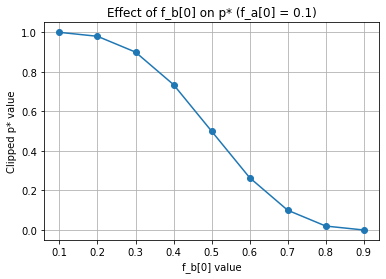

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
domain = list(range(1))  # Single element domain: [0]
f_a = {0: 0.1}
epsilon = 0.1
n = 1000

# Function as provided
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0   / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1)) for v in domain)
    α2 = sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den = a1**2/(2*n) - α2/(4*d)

    p_star = num/den if den != 0 else 0.0
    py_clipped = float(np.clip(p_star, 0.0, 1.0))
    return py_clipped

# Generate values for f_b and compute results
fb_values = np.arange(0.1, 1.0, 0.1)
py_values = []

for fb_val in fb_values:
    f_b = {0: fb_val}
    py = optimal_p_y(f_a, f_b, epsilon, n, domain)
    py_values.append(py)

# Plotting the results
plt.figure()
plt.plot(fb_values, py_values, marker='o')
plt.xlabel('f_b[0] value')
plt.ylabel('Clipped p* value')
plt.title('Effect of f_b[0] on p* (f_a[0] = 0.1)')
plt.grid(True)
plt.show()


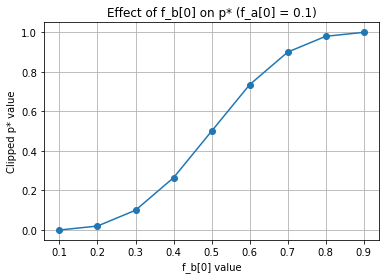

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
domain = list(range(1))  # Single element domain: [0]
f_a = {0: 0.9}
epsilon = 0.1
n = 1000

# Function as provided
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0   / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1)) for v in domain)
    α2 = sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den = a1**2/(2*n) - α2/(4*d)

    p_star = num/den if den != 0 else 0.0
    py_clipped = float(np.clip(p_star, 0.0, 1.0))
    return py_clipped

# Generate values for f_b and compute results
fb_values = np.arange(0.1, 1.0, 0.1)
py_values = []

for fb_val in fb_values:
    f_b = {0: fb_val}
    py = optimal_p_y(f_a, f_b, epsilon, n, domain)
    py_values.append(py)

# Plotting the results
plt.figure()
plt.plot(fb_values, py_values, marker='o')
plt.xlabel('f_b[0] value')
plt.ylabel('Clipped p* value')
plt.title('Effect of f_b[0] on p* (f_a[0] = 0.1)')
plt.grid(True)
plt.show()


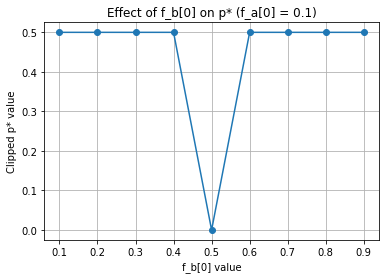

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
domain = list(range(1))  # Single element domain: [0]
f_a = {0: 0.5}
epsilon = 0.1
n = 1000

# Function as provided
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0   / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1)) for v in domain)
    α2 = sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den = a1**2/(2*n) - α2/(4*d)

    p_star = num/den if den != 0 else 0.0
    py_clipped = float(np.clip(p_star, 0.0, 1.0))
    return py_clipped

# Generate values for f_b and compute results
fb_values = np.arange(0.1, 1.0, 0.1)
py_values = []

for fb_val in fb_values:
    f_b = {0: fb_val}
    py = optimal_p_y(f_a, f_b, epsilon, n, domain)
    py_values.append(py)

# Plotting the results
plt.figure()
plt.plot(fb_values, py_values, marker='o')
plt.xlabel('f_b[0] value')
plt.ylabel('Clipped p* value')
plt.title('Effect of f_b[0] on p* (f_a[0] = 0.1)')
plt.grid(True)
plt.show()


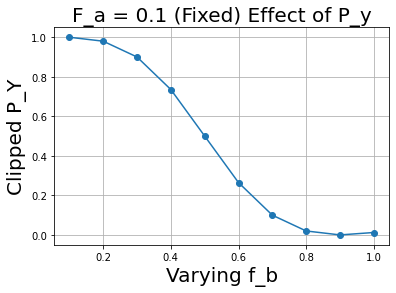

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
domain = list(range(1))  # Single element domain: [0]
f_a = {0: 0.1}
epsilon = 0.1
n = 1000

# Function as provided
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0   / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1)) for v in domain)
    α2 = sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den = a1**2/(2*n) - α2/(4*d)

    p_star = num/den if den != 0 else 0.0
    py_clipped = float(np.clip(p_star, 0.0, 1.0))
    return p_star

# Generate values for f_b and compute results
fb_values = np.arange(0.1, 1.1, 0.1)
py_values = []

for fb_val in fb_values:
    f_b = {0: fb_val}
    py = optimal_p_y(f_a, f_b, epsilon, n, domain)
    py_values.append(py)

# Plotting the results
plt.figure()
plt.plot(fb_values, py_values, marker='o')
plt.xlabel('Varying f_b', fontsize=20)
plt.ylabel('Clipped P_Y', fontsize=20)
plt.title('F_a = 0.1 (Fixed) Effect of P_y', fontsize=20)
plt.grid(True)
plt.show()


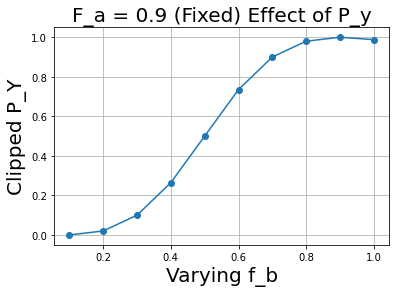

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
domain = list(range(1))  # Single element domain: [0]
f_a = {0: 0.9}
epsilon = 0.1
n = 1000

# Function as provided
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0   / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1)) for v in domain)
    α2 = sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den = a1**2/(2*n) - α2/(4*d)

    p_star = num/den if den != 0 else 0.0
    py_clipped = float(np.clip(p_star, 0.0, 1.0))
    return py_clipped

# Generate values for f_b and compute results
fb_values = np.arange(0.1, 1.1, 0.1)
py_values = []

for fb_val in fb_values:
    f_b = {0: fb_val}
    py = optimal_p_y(f_a, f_b, epsilon, n, domain)
    py_values.append(py)

# Plotting the results
plt.figure()
plt.plot(fb_values, py_values, marker='o')
plt.xlabel('Varying f_b', fontsize=20)
plt.ylabel('Clipped P_Y', fontsize=20)
plt.title('F_a = 0.9 (Fixed) Effect of P_y', fontsize=20)
plt.grid(True)
plt.show()


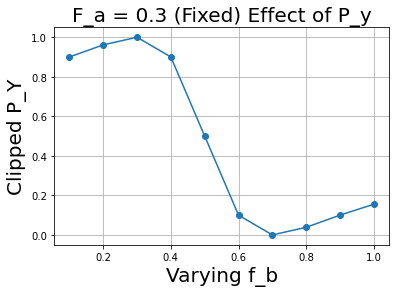

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
domain = list(range(1))  # Single element domain: [0]
f_a = {0: 0.3}
epsilon = 0.1
n = 1000

# Function as provided
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0   / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1)) for v in domain)
    α2 = sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den = a1**2/(2*n) - α2/(4*d)

    p_star = num/den if den != 0 else 0.0
    py_clipped = float(np.clip(p_star, 0.0, 1.0))
    return py_clipped

# Generate values for f_b and compute results
fb_values = np.arange(0.1, 1.1, 0.1)
py_values = []

for fb_val in fb_values:
    f_b = {0: fb_val}
    py = optimal_p_y(f_a, f_b, epsilon, n, domain)
    py_values.append(py)

# Plotting the results
plt.figure()
plt.plot(fb_values, py_values, marker='o')
plt.xlabel('Varying f_b', fontsize=20)
plt.ylabel('Clipped P_Y', fontsize=20)
plt.title('F_a = 0.3 (Fixed) Effect of P_y', fontsize=20)
plt.grid(True)
plt.show()


0.5
0.5
0.5
0.5
1
0.5
0.5
0.5
0.5
0.5


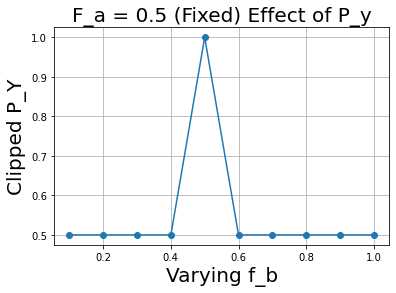

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
domain = list(range(1))  # Single element domain: [0]
f_a = {0: 0.5}
epsilon = 10
n = 1000

# Function as provided
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0   / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1)) for v in domain)
    α2 = sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den = a1**2/(2*n) - α2/(4*d)

    p_star = num/den if den != 0 else 1
  
    py_clipped = float(np.clip(p_star, 0.0, 1.0))
    print(p_star)
    return p_star

# Generate values for f_b and compute results
fb_values = np.arange(0.1, 1.1, 0.1)
py_values = []

for fb_val in fb_values:
    f_b = {0: fb_val}
    py = optimal_p_y(f_a, f_b, epsilon, n, domain)
    py_values.append(py)

# Plotting the results
plt.figure()
plt.plot(fb_values, py_values, marker='o')
plt.xlabel('Varying f_b', fontsize=20)
plt.ylabel('Clipped P_Y', fontsize=20)
plt.title('F_a = 0.5 (Fixed) Effect of P_y', fontsize=20)
plt.grid(True)
plt.show()


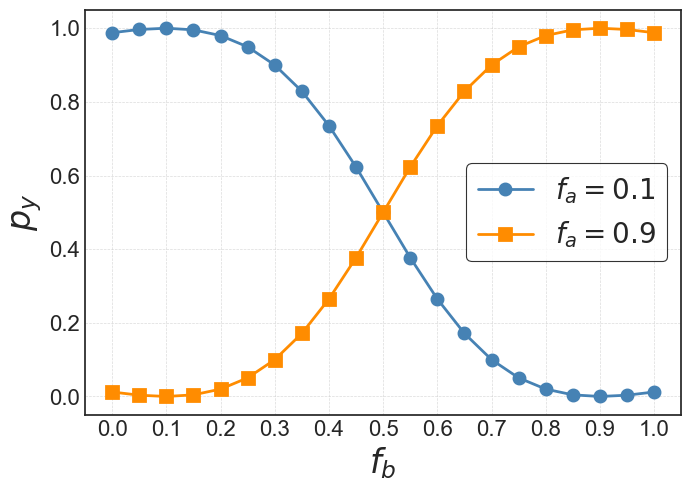

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
domain = list(range(1))  # Single-element domain [0]
epsilon = 0.1
n = 1000

# Function to compute optimal p_y
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0 / (exp_eps + d - 1)
    Δ = p - q

    S1 = d * (d - 1) / 2
    S2 = (d - 1) * d * (2 * d - 1) / 6

    μa = sum(v * f_a[v] for v in domain)
    μb = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2 * μb - S1
    b1 = 2 * νb2 - S2
    Y0 = (Δ / 2) * a0 + (S1 / 2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2 * f_a[v] - 1) + (2 * f_b[v] - 1)) for v in domain)
    α2 = sum((2 * f_a[v] - 1)**2 + (2 * f_b[v] - 1)**2 for v in domain)

    num = (b1 - 2 * Y0 * a1) / (2 * n * Δ) + α1 / (8 * d)
    den = a1**2 / (2 * n) - α2 / (4 * d)

    p_star = num / den if den != 0 else q
    return float(np.clip(p_star, 0.0, 1.0))

# Plot configuration
fb_values = np.linspace(0, 1, 21)
fa_values = [0.1, 0.9]
colors = ['steelblue', 'darkorange']
labels = [r'$f_a = 0.1$', r'$f_a = 0.9$']
markers = ['o', 's']

plt.figure(figsize=(7, 5))

# Generate and plot curves
for fa_val, color, label, marker in zip(fa_values, colors, labels, markers):
    f_a = {0: fa_val}
    py_values = []
    for fb_val in fb_values:
        f_b = {0: fb_val}
        py = optimal_p_y(f_a, f_b, epsilon, n, domain)
        py_values.append(py)
    plt.plot(fb_values, py_values, label=label, color=color,
             marker=marker, linewidth=2, markersize=8,
             markeredgewidth=2)

# Axis and title styling
plt.xlabel(r'$f_b$', fontsize=24)
plt.ylabel(r'$p_y$', fontsize=24)
#plt.title(r'Effect of $f_b$ on $p_y$ for Different $f_a$', fontsize=20)
plt.xticks(np.linspace(0, 1, 11), fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=20, frameon=True, edgecolor='black')
plt.tight_layout()
#plt.show()
plt.savefig("py_extreme.pdf", bbox_inches='tight')
plt.show()

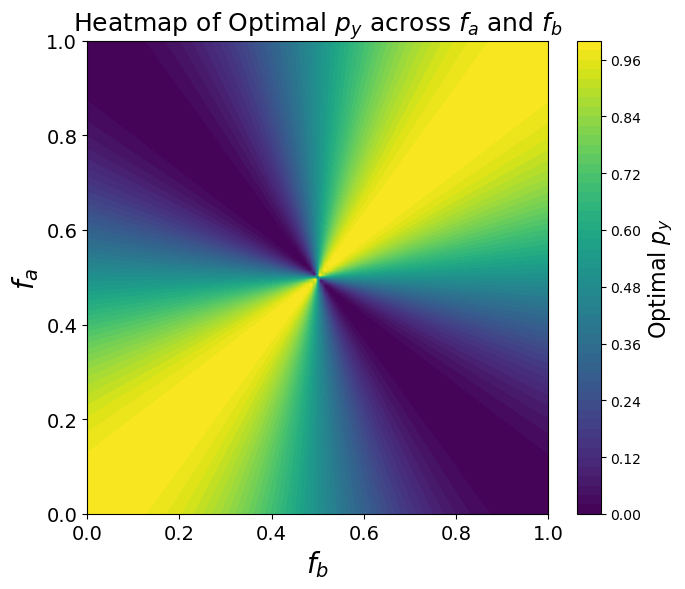

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
domain = [0, 1]
epsilon = 0.1
n = 1000

def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0 / (exp_eps + d - 1)
    Δ = p - q

    S1 = d * (d - 1) / 2
    S2 = (d - 1) * d * (2 * d - 1) / 6

    μa = sum(v * f_a[v] for v in domain)
    μb = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2 * μb - S1
    b1 = 2 * νb2 - S2
    Y0 = (Δ / 2) * a0 + (S1 / 2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2 * f_a[v] - 1) + (2 * f_b[v] - 1)) for v in domain)
    α2 = sum((2 * f_a[v] - 1)**2 + (2 * f_b[v] - 1)**2 for v in domain)

    num = (b1 - 2 * Y0 * a1) / (2 * n * Δ) + α1 / (8 * d)
    den = a1**2 / (2 * n) - α2 / (4 * d)

    p_star = num / den if den != 0 else q
    return float(np.clip(p_star, 0.0, 1.0))

# Frequency grid
freq_vals = np.linspace(0, 1, 100)
f_a_vals, f_b_vals = np.meshgrid(freq_vals, freq_vals)
p_y_vals = np.zeros_like(f_a_vals)

# Evaluate p_y over the grid
for i in range(f_a_vals.shape[0]):
    for j in range(f_a_vals.shape[1]):
        fa = f_a_vals[i, j]
        fb = f_b_vals[i, j]
        f_a = {0: fa, 1: 1 - fa}
        f_b = {0: fb, 1: 1 - fb}
        p_y_vals[i, j] = optimal_p_y(f_a, f_b, epsilon, n, domain)

# Plotting
plt.figure(figsize=(7, 6))
contour = plt.contourf(f_b_vals, f_a_vals, p_y_vals, levels=50, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_label(r'Optimal $p_y$', fontsize=16)
plt.xlabel(r'$f_b$', fontsize=20)
plt.ylabel(r'$f_a$', fontsize=20)
plt.title(r'Heatmap of Optimal $p_y$ across $f_a$ and $f_b$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()


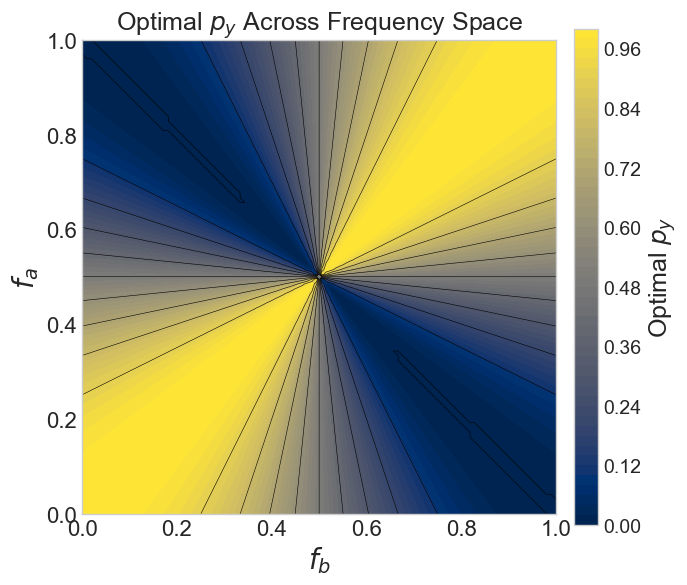

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for consistency
sns.set_context("paper")
plt.style.use('seaborn-v0_8-whitegrid')  # modern, clean background

# Constants
domain = [0, 1]
epsilon = 0.1
n = 1000

def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0 / (exp_eps + d - 1)
    Δ = p - q

    S1 = d * (d - 1) / 2
    S2 = (d - 1) * d * (2 * d - 1) / 6

    μa = sum(v * f_a[v] for v in domain)
    μb = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2 * μb - S1
    b1 = 2 * νb2 - S2
    Y0 = (Δ / 2) * a0 + (S1 / 2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2 * f_a[v] - 1) + (2 * f_b[v] - 1)) for v in domain)
    α2 = sum((2 * f_a[v] - 1)**2 + (2 * f_b[v] - 1)**2 for v in domain)

    num = (b1 - 2 * Y0 * a1) / (2 * n * Δ) + α1 / (8 * d)
    den = a1**2 / (2 * n) - α2 / (4 * d)

    p_star = num / den if den != 0 else q
    return float(np.clip(p_star, 0.0, 1.0))

# Frequency grid
freq_vals = np.linspace(0, 1, 100)
f_a_vals, f_b_vals = np.meshgrid(freq_vals, freq_vals)
p_y_vals = np.zeros_like(f_a_vals)

# Evaluate p_y over the grid
for i in range(f_a_vals.shape[0]):
    for j in range(f_a_vals.shape[1]):
        fa = f_a_vals[i, j]
        fb = f_b_vals[i, j]
        f_a = {0: fa, 1: 1 - fa}
        f_b = {0: fb, 1: 1 - fb}
        p_y_vals[i, j] = optimal_p_y(f_a, f_b, epsilon, n, domain)

# Plotting
fig, ax = plt.subplots(figsize=(7, 6))

# Filled contour
contour = ax.contourf(f_b_vals, f_a_vals, p_y_vals, levels=50, cmap='cividis')
# Contour lines
ax.contour(f_b_vals, f_a_vals, p_y_vals, levels=10, colors='black', linewidths=0.4)

# Colorbar
cbar = fig.colorbar(contour, ax=ax, pad=0.03)
cbar.set_label(r'Optimal $p_y$', fontsize=18)
cbar.ax.tick_params(labelsize=14)

# Axis settings
ax.set_xlabel(r'$f_b$', fontsize=20)
ax.set_ylabel(r'$f_a$', fontsize=20)
ax.set_title(r'Optimal $p_y$ Across Frequency Space', fontsize=18)
ax.set_xticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 6))
ax.tick_params(labelsize=16)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


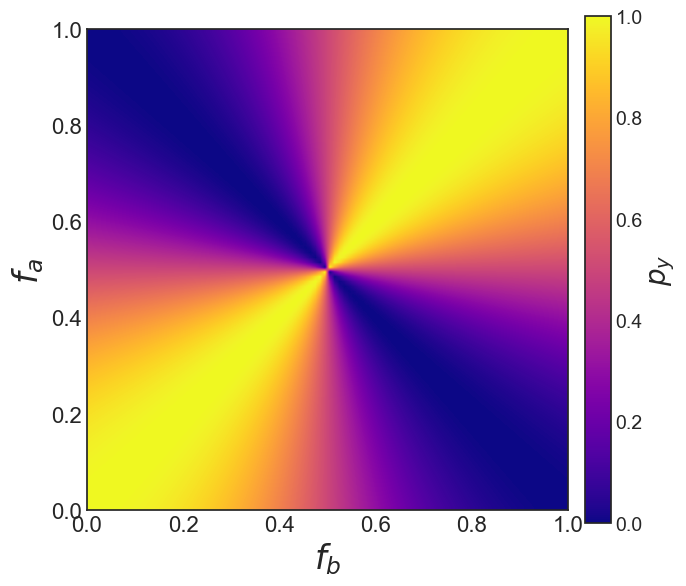

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Style setup
sns.set_context("paper")
plt.style.use("seaborn-v0_8-white")

# Constants
domain = [0, 1]
epsilon = 0.1
n = 1000

# p_y function
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0 / (exp_eps + d - 1)
    Δ = p - q

    S1 = d * (d - 1) / 2
    S2 = (d - 1) * d * (2 * d - 1) / 6

    μa = sum(v * f_a[v] for v in domain)
    μb = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2 * μb - S1
    b1 = 2 * νb2 - S2
    Y0 = (Δ / 2) * a0 + (S1 / 2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2 * f_a[v] - 1) + (2 * f_b[v] - 1)) for v in domain)
    α2 = sum((2 * f_a[v] - 1)**2 + (2 * f_b[v] - 1)**2 for v in domain)

    num = (b1 - 2 * Y0 * a1) / (2 * n * Δ) + α1 / (8 * d)
    den = a1**2 / (2 * n) - α2 / (4 * d)

    p_star = num / den if den != 0 else q
    return float(np.clip(p_star, 0.0, 1.0))

# Grid
vals = np.linspace(0, 1, 100)
f_a_vals, f_b_vals = np.meshgrid(vals, vals)
p_y_vals = np.zeros_like(f_a_vals)

# Compute heatmap
for i in range(f_a_vals.shape[0]):
    for j in range(f_a_vals.shape[1]):
        fa = f_a_vals[i, j]
        fb = f_b_vals[i, j]
        f_a = {0: fa, 1: 1 - fa}
        f_b = {0: fb, 1: 1 - fb}
        p_y_vals[i, j] = optimal_p_y(f_a, f_b, epsilon, n, domain)

# Plot
fig, ax = plt.subplots(figsize=(7, 6))
img = ax.imshow(p_y_vals, origin='lower', extent=[0, 1, 0, 1],
                cmap='plasma', aspect='equal', interpolation='bilinear')

# Colorbar
cbar = fig.colorbar(img, ax=ax, pad=0.03)
cbar.set_label(r'$p_y$', fontsize=20)
cbar.ax.tick_params(labelsize=14)

# Labels and ticks
ax.set_xlabel(r'$f_b$', fontsize=24)
ax.set_ylabel(r'$f_a$', fontsize=24)
#ax.set_title(r'Optimal $p_y$ Across Frequency Space', fontsize=18)
ax.set_xticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 6))
ax.tick_params(labelsize=16)

plt.tight_layout()
plt.savefig("py_heat.pdf", bbox_inches='tight')

plt.show()


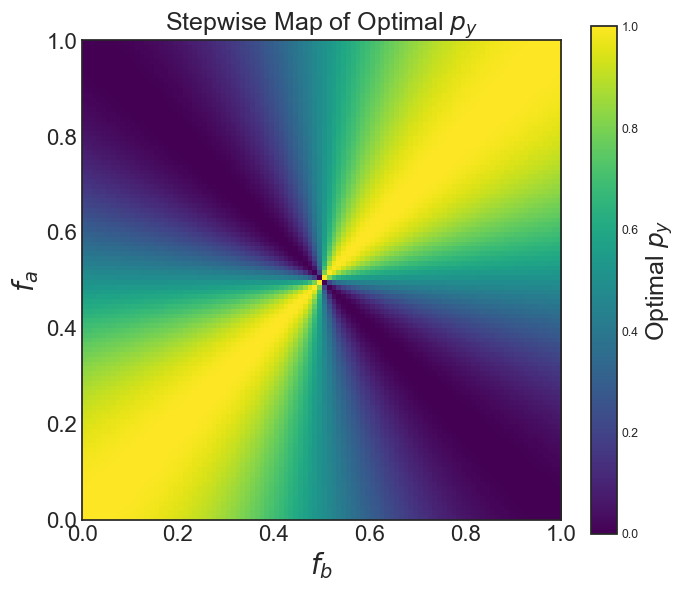

In [16]:
plt.figure(figsize=(7, 6))
img = plt.imshow(p_y_vals, origin='lower', extent=[0, 1, 0, 1],
                 cmap='viridis', aspect='equal', interpolation='nearest')  # No smoothing
cbar = plt.colorbar(img)
cbar.set_label(r'Optimal $p_y$', fontsize=18)
plt.xlabel(r'$f_b$', fontsize=20)
plt.ylabel(r'$f_a$', fontsize=20)
plt.title(r'Stepwise Map of Optimal $p_y$', fontsize=18)
plt.xticks(np.linspace(0, 1, 6), fontsize=16)
plt.yticks(np.linspace(0, 1, 6), fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.show()

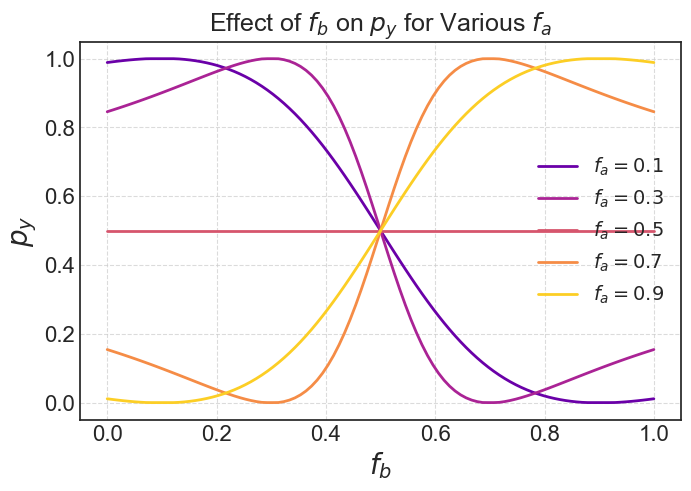

In [18]:
fa_fixed_values = [0.1, 0.3, 0.5, 0.7, 0.9]
colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(fa_fixed_values)))

plt.figure(figsize=(7, 5))
for fa_val, color in zip(fa_fixed_values, colors):
    p_y_line = []
    for fb_val in vals:
        f_a = {0: fa_val, 1: 1 - fa_val}
        f_b = {0: fb_val, 1: 1 - fb_val}
        p_y_line.append(optimal_p_y(f_a, f_b, epsilon, n, domain))
    plt.plot(vals, p_y_line, label=fr'$f_a={fa_val}$', color=color, linewidth=2)

plt.xlabel(r'$f_b$', fontsize=20)
plt.ylabel(r'$p_y$', fontsize=20)
plt.title(r'Effect of $f_b$ on $p_y$ for Various $f_a$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


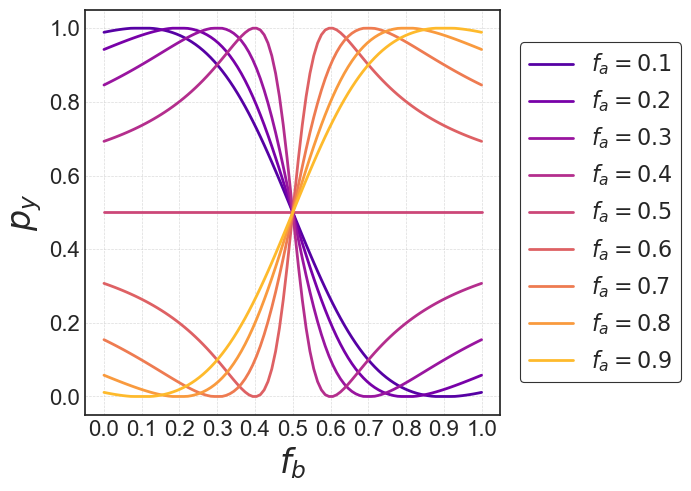

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
domain = [0, 1]  # Binary domain
epsilon = 0.1
n = 1000

# Function to compute optimal p_y
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0 / (exp_eps + d - 1)
    Δ = p - q

    S1 = d * (d - 1) / 2
    S2 = (d - 1) * d * (2 * d - 1) / 6

    μa = sum(v * f_a[v] for v in domain)
    μb = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2 * μb - S1
    b1 = 2 * νb2 - S2
    Y0 = (Δ / 2) * a0 + (S1 / 2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2 * f_a[v] - 1) + (2 * f_b[v] - 1)) for v in domain)
    α2 = sum((2 * f_a[v] - 1)**2 + (2 * f_b[v] - 1)**2 for v in domain)

    num = (b1 - 2 * Y0 * a1) / (2 * n * Δ) + α1 / (8 * d)
    den = a1**2 / (2 * n) - α2 / (4 * d)

    p_star = num / den if den != 0 else q
    return float(np.clip(p_star, 0.0, 1.0))

# Configuration
fa_fixed_values = [0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = plt.cm.plasma(np.linspace(0.15, 0.85, len(fa_fixed_values)))
fb_values = np.linspace(0, 1, 100)

# Plot
plt.figure(figsize=(7, 5))
for fa_val, color in zip(fa_fixed_values, colors):
    py_values = []
    for fb_val in fb_values:
        f_a = {0: fa_val, 1: 1 - fa_val}
        f_b = {0: fb_val, 1: 1 - fb_val}
        py_values.append(optimal_p_y(f_a, f_b, epsilon, n, domain))
    plt.plot(fb_values, py_values, color=color, linewidth=2, label=fr'$f_a = {fa_val}$')

# Styling
plt.xlabel(r'$f_b$', fontsize=24)
plt.ylabel(r'$p_y$', fontsize=24)
#plt.title(r'Effect of $f_b$ on $p_y$ for Various $f_a$', fontsize=20)
plt.xticks(np.linspace(0, 1, 11), fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=16, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, edgecolor='black')
plt.tight_layout()
plt.tight_layout()
plt.savefig("py_all.pdf", bbox_inches='tight')

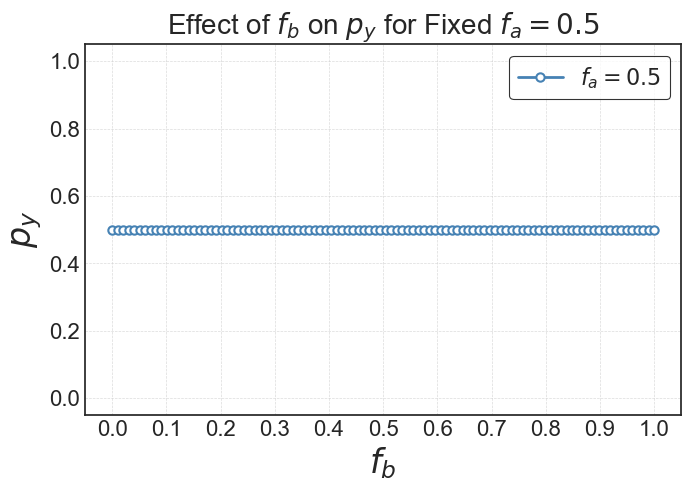

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
domain = [0, 1]  # Binary domain
f_a = {0: 0.5, 1: 0.5}  # Proper binary marginal
epsilon = 10
n = 1000

# Function to compute optimal p_y
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0 / (exp_eps + d - 1)
    Δ = p - q

    S1 = d * (d - 1) / 2
    S2 = (d - 1) * d * (2 * d - 1) / 6

    μa = sum(v * f_a[v] for v in domain)
    μb = sum(v * f_b[v] for v in domain)
    νb2 = sum(v ** 2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2 * μb - S1
    b1 = 2 * νb2 - S2
    Y0 = (Δ / 2) * a0 + (S1 / 2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2 * f_a[v] - 1) + (2 * f_b[v] - 1)) for v in domain)
    α2 = sum((2 * f_a[v] - 1)**2 + (2 * f_b[v] - 1)**2 for v in domain)

    num = (b1 - 2 * Y0 * a1) / (2 * n * Δ) + α1 / (8 * d)
    den = a1 ** 2 / (2 * n) - α2 / (4 * d)

    p_star = num / den if den != 0 else 0
    return float(np.clip(p_star, 0.0, 1.0))

# Generate values for f_b and compute results
fb_values = np.linspace(0, 1, 100)
py_values = []

for fb_val in fb_values:
    f_b = {0: fb_val, 1: 1 - fb_val}
    py = optimal_p_y(f_a, f_b, epsilon, n, domain)
    py_values.append(py)

# Plotting
plt.figure(figsize=(7, 5))
plt.plot(fb_values, py_values, marker='o', markersize=6, markerfacecolor='white',
         markeredgewidth=1.5, linewidth=2, color='steelblue', label=r'$f_a = 0.5$')

# Styling
plt.xlabel(r'$f_b$', fontsize=24)
plt.ylabel(r'$p_y$', fontsize=24)
plt.title(r'Effect of $f_b$ on $p_y$ for Fixed $f_a = 0.5$', fontsize=20)
plt.xticks(np.linspace(0, 1, 11), fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=16, frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()


0.5
0.5
0.5
0.5
1
0.5
0.5
0.5
0.5
0.5


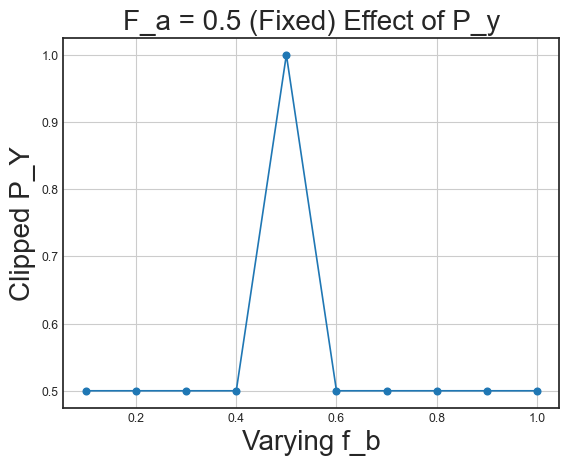

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
domain = list(range(1))  # Single element domain: [0]
f_a = {0: 0.5}
epsilon = 10
n = 1000

# Function as provided
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0   / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1)) for v in domain)
    α2 = sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den = a1**2/(2*n) - α2/(4*d)

    p_star = num/den if den != 0 else 1
  
    py_clipped = float(np.clip(p_star, 0.0, 1.0))
    print(p_star)
    return p_star

# Generate values for f_b and compute results
fb_values = np.arange(0.1, 1.1, 0.1)
py_values = []

for fb_val in fb_values:
    f_b = {0: fb_val}
    py = optimal_p_y(f_a, f_b, epsilon, n, domain)
    py_values.append(py)

# Plotting the results
plt.figure()
plt.plot(fb_values, py_values, marker='o')
plt.xlabel('Varying f_b', fontsize=20)
plt.ylabel('Clipped P_Y', fontsize=20)
plt.title('F_a = 0.5 (Fixed) Effect of P_y', fontsize=20)
plt.grid(True)
plt.show()


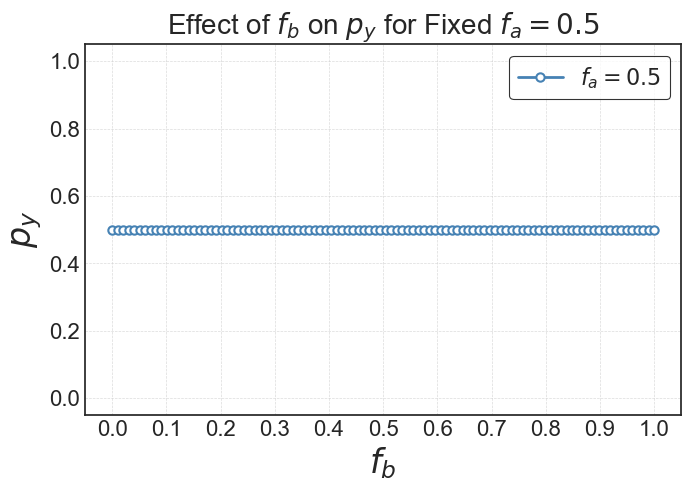

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
domain = [0, 1]  # Proper binary domain
f_a = {0: 0.5, 1: 0.5}  # Balanced marginal for X_a
epsilon = 10
n = 1000

# Function to compute optimal p_y
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0 / (exp_eps + d - 1)
    Δ = p - q

    S1 = d * (d - 1) / 2
    S2 = (d - 1) * d * (2 * d - 1) / 6

    μa = sum(v * f_a[v] for v in domain)
    μb = sum(v * f_b[v] for v in domain)
    νb2 = sum(v ** 2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2 * μb - S1
    b1 = 2 * νb2 - S2
    Y0 = (Δ / 2) * a0 + (S1 / 2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2 * f_a[v] - 1) + (2 * f_b[v] - 1)) for v in domain)
    α2 = sum((2 * f_a[v] - 1)**2 + (2 * f_b[v] - 1)**2 for v in domain)

    num = (b1 - 2 * Y0 * a1) / (2 * n * Δ) + α1 / (8 * d)
    den = a1 ** 2 / (2 * n) - α2 / (4 * d)

    p_star = num / den if den != 0 else 1.0
    return float(np.clip(p_star, 0.0, 1.0))

# Generate values for f_b and compute results
fb_values = np.linspace(0, 1, 100)
py_values = []

for fb_val in fb_values:
    f_b = {0: fb_val, 1: 1 - fb_val}
    py = optimal_p_y(f_a, f_b, epsilon, n, domain)
    py_values.append(py)

# Plotting
plt.figure(figsize=(7, 5))
plt.plot(fb_values, py_values, marker='o', markersize=6,
         markerfacecolor='white', markeredgewidth=1.5,
         linewidth=2, color='steelblue', label=r'$f_a = 0.5$')

# Styling
plt.xlabel(r'$f_b$', fontsize=24)
plt.ylabel(r'$p_y$', fontsize=24)
plt.title(r'Effect of $f_b$ on $p_y$ for Fixed $f_a = 0.5$', fontsize=20)
plt.xticks(np.linspace(0, 1, 11), fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=16, frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()
